# Introduction to DESI Everest Spectroscopic Data Release

Ragadeepika Pucha, Anthony Kremin <br/>
DESI Pre-Meeting, December 2021

## Table of Contents

* [Overview](#overview)
* [Imports](#import)
* [Accessing the data](#data_access)
    * [Summary Files](#sumfiles)
    * [Redshift Catalogs](#zcatalog)
    * [Selecting sources based on Targeting Information](#targets)
    * [Healpix/ Directory](#hpx)
* [Accessing and Plotting Spectra of a Single Object](#spectra_access)
    * [Coadded Spectra](#spectra)
* [Brief Overview of Bits, Bitmasks, and Flags](#bits)

<a class="anchor" id="overview"></a>
# Overview

In this notebook, we will explore the DESI data file structure in the everest release. We will focus on the healpix based files in this notebook. The files in this release are divided based on `HPXPIXEL`, `SURVEY`, and `FAPRGRM`. 

### Bug Reporting
If you identify any errors or have requests for additional functionality please create a new issue at https://github.com/desihub/tutorials/issues or send a note to desi-data@desi.lbl.gov.

### Getting Started

#### Using NERSC

The easiest way to get started is to use the jupyter server at NERSC so that you don't need to
install any code or download any data locally.

If you need a NERSC account, see https://desi.lbl.gov/trac/wiki/Computing/AccessNersc

Then do the one-time jupyter configuration described at https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC

From a NERSC command line, checkout a copy of the tutorial code, *e.g.* from cori.nersc.gov
```console
mkdir -p $HOME/desi/
cd $HOME/desi/
git clone https://github.com/desihub/tutorials
```
And then go to https://jupyter.nersc.gov, login, navigate to where you checked out this package (*e.g.* `$HOME/desi/tutorials/Dec2021`), and double-click on `Everest_Tutorial_Dec2021.ipynb`.


#### Setting up the DESI environment (kernel)
For those working through this in Dec. 2021, you can use the DESI master kernel in jupyterhub. For those referring to this in 2022 or beyond: this tutorial has been tested using the "DESI 22.2" kernel installed at NERSC. If you don't see that installed, you will need to open a terminal either in jupyterhub or via an actual terminal logged in to NERSC and do the following:

```console
source /global/common/software/desi/cori/desiconda/startup/modulefiles/desimodules/install_jupyter_kernel.sh 22.2
```
You'll then need to restart your jupyterhub instance to see the kernel. After following the step above and restarting: you can go to the Kernel menu, select "Change Kernel", then select 'DESI 22.2' from the dropdown menu.

To get an equivalent environment from a cori command line:
```console
source /global/common/software/desi/desi_environment.sh 22.2
```

<a class="anchor" id="import"></a>
# Imports

In [1]:
# import some helpful python packages 
import os
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib 
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

# DESI targeting masks - 
## Note that we are importing the different target masks for different surveys by the same name.
## This is to allow you to run the same cells in the tutorial for different surveys bitmasks.
## Please make sure to uncomment the required survey and comment out the rest, 
## and rerun this cell, to make sure everything runs smoothly.
from desitarget.targetmask import desi_mask, bgs_mask, scnd_mask    # For the main survey
#from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, scnd_mask    # For SV1
#from desitarget.sv2.sv2_targetmask import desi_mask, bgs_mask, scnd_mask    # For SV2
#from desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, scnd_mask    # For SV3

In [3]:
## Making the matplotlib plots look nicer
settings = {
    'font.size':22,
    'axes.linewidth':3.0,
    'xtick.major.size':6.0,
    'xtick.minor.size':4.0,
    'xtick.major.width':3.0,
    'xtick.minor.width':1.5,
    'xtick.direction':'in', 
    'xtick.minor.visible':True,
    'xtick.top':True,
    'ytick.major.size':6.0,
    'ytick.minor.size':4.0,
    'ytick.major.width':3.0,
    'ytick.minor.width':1.5,
    'ytick.direction':'in', 
    'ytick.minor.visible':True,
    'ytick.right':True
}

plt.rcParams.update(**settings)

<a class="anchor" id="data_access"></a>
# Accessing the data

Everest is the fifth internal DESI spectroscopic data release. It consists of the whole SV data (includes SV1, SV2, and SV3) and the first few months of data from the main survey. More information about this release is available [here](https://desi.lbl.gov/trac/wiki/Pipeline/Releases/Everest). 

In [4]:
# Release directory path

specprod = 'everest'
everest_dir = f'/global/cfs/cdirs/desi/spectro/redux/{specprod}'

In [5]:
# Listing everything in this directory 
os.listdir(everest_dir)

['healpix',
 'tiles',
 'exposures-everest.csv',
 'run',
 'calibnight',
 'exposures',
 'processing_tables',
 'preproc',
 'exposures-everest.fits',
 'tiles-everest.csv',
 'exposure_tables',
 'zcatalog']

### Important Files to Note:

1. exposures-everest.fits -- This consists of information about individual exposures of the targets
2. tiles-everest.csv -- This contains information about the observed tiles
3. zcatalog/ Directory -- This directory contains all of the summary redshift catalogs
4. tiles/ Directory -- This directory holds all of the per-tile coadds and redshifts, in various flavors.
5. healpix/ Directory -- This directory holds all of the coadds and redshifts based on sky location (healpix).

<a class="anchor" id="sumfiles"></a>

## Summary Files

Let's take a look at the tiles and exposure files

### tiles-everest.csv
This file tells you what tiles were observed, what survey and program they were observed for, some obseving conditions, and three estimates of the "effective time" (in seconds) that each tile acquired. The time estimate used for survey operations decisions is `EFFTIME_SPEC`.

For the main survey `ZDONE` will determine whether the tile was successfully observed to sufficient depth to be considered done observing. For SV that is still generally true.

In [6]:
tiles_table = Table.read(f'{everest_dir}/tiles-{specprod}.csv',format='ascii.csv')
print(f"Tiles table columns: {tiles_table.colnames}")
tiles_table[:5].show_in_notebook()

Tiles table columns: ['TILEID', 'SURVEY', 'FAPRGRM', 'FAFLAVOR', 'NEXP', 'EXPTIME', 'TILERA', 'TILEDEC', 'EFFTIME_ETC', 'EFFTIME_SPEC', 'EFFTIME_GFA', 'GOALTIME', 'OBSSTATUS', 'ZDONE', 'ELG_EFFTIME_DARK', 'BGS_EFFTIME_BRIGHT', 'LYA_EFFTIME_DARK', 'GOALTYPE', 'MINTFRAC', 'LASTNIGHT', 'QA', 'USER']


idx,TILEID,SURVEY,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,ZDONE,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT,QA,USER
0,1,sv3,dark,sv3dark,3,2299.4,150.04,2.286,1409.3,1621.8,1423.6,1200.0,obsend,true,1621.8,1598.7,1535.4,dark,0.9,20210406,none,none
1,2,sv3,dark,sv3dark,2,1900.4,150.061,2.069,1411.1,1338.7,1366.6,1200.0,obsend,true,1338.7,1333.2,1351.2,dark,0.9,20210407,none,none
2,3,sv3,dark,sv3dark,1,951.5,150.212,2.226,1404.7,1435.2,1287.4,1200.0,obsend,true,1435.2,1365.9,1711.6,dark,0.9,20210409,none,none
3,4,sv3,dark,sv3dark,1,1065.1,149.98,2.171,1415.1,1460.5,1238.8,1200.0,obsend,true,1460.5,1381.4,1769.7,dark,0.9,20210410,none,none
4,5,sv3,dark,sv3dark,2,1656.9,150.187,2.099,1402.2,1398.0,1361.3,1200.0,obsend,true,1398.0,1408.8,1556.4,dark,0.9,20210412,none,none


Let's use this to find the number of tiles in each survey, each program, and each FAFLAVOR

In [7]:
for survey in ['cmx', 'sv1', 'sv2', 'sv3', 'main']:
    print(f'{survey}: Ntiles={np.sum(tiles_table["SURVEY"]==survey)}')

cmx: Ntiles=180
sv1: Ntiles=189
sv2: Ntiles=40
sv3: Ntiles=489
main: Ntiles=662


In [8]:
for faprgrm in ['bright', 'dark']:
    print(f'{faprgrm}: Ntiles={np.sum(tiles_table["FAPRGRM"]==faprgrm)}')

bright: Ntiles=588
dark: Ntiles=587


In [9]:
for faflavor in np.unique(tiles_table["FAFLAVOR"]):
    print(f'{faflavor}: \tNtiles={np.sum(tiles_table["FAFLAVOR"]==faflavor)}')

cmxelg: 	Ntiles=3
cmxlrgqso: 	Ntiles=3
cmxm33: 	Ntiles=1
dithfocus: 	Ntiles=34
dithlost: 	Ntiles=11
dithprec: 	Ntiles=144
mainbright: 	Ntiles=352
maindark: 	Ntiles=310
specialbright: 	Ntiles=4
specialdark: 	Ntiles=17
sv1backup1: 	Ntiles=26
sv1bgsmws: 	Ntiles=50
sv1dc3r2: 	Ntiles=4
sv1elg: 	Ntiles=22
sv1elgqso: 	Ntiles=12
sv1lrgqso: 	Ntiles=28
sv1lrgqso2: 	Ntiles=12
sv1m31: 	Ntiles=2
sv1mwclusgaldeep: 	Ntiles=2
sv1praesepe: 	Ntiles=1
sv1rosette: 	Ntiles=1
sv1scndcosmos: 	Ntiles=2
sv1scndhetdex: 	Ntiles=2
sv1ssv: 	Ntiles=15
sv1umaii: 	Ntiles=1
sv1unwisebluebright: 	Ntiles=1
sv1unwisebluefaint: 	Ntiles=1
sv1unwisegreen: 	Ntiles=1
sv2backup: 	Ntiles=1
sv2bright: 	Ntiles=18
sv2dark: 	Ntiles=21
sv3backup: 	Ntiles=36
sv3bright: 	Ntiles=214
sv3dark: 	Ntiles=239


### exposures-everest.fits
Formerly known as `tsnr-{specprod}.fits`. This file is primarily used for daily operations, but can be handy for looking at individual exposures and the amount of "EFFECTIVE TIME" that exposure acquired.

In [10]:
exp_table = Table.read(f'{everest_dir}/exposures-{specprod}.fits', format='fits', hdu='EXPOSURES')
print(f"Tiles table columns: {exp_table.colnames}")
exp_table[-5:].show_in_notebook()

Tiles table columns: ['NIGHT', 'EXPID', 'TILEID', 'TILERA', 'TILEDEC', 'MJD', 'SURVEY', 'FAPRGRM', 'FAFLAVOR', 'EXPTIME', 'EFFTIME_SPEC', 'GOALTIME', 'GOALTYPE', 'MINTFRAC', 'AIRMASS', 'EBV', 'SEEING_ETC', 'EFFTIME_ETC', 'TSNR2_ELG', 'TSNR2_QSO', 'TSNR2_LRG', 'TSNR2_LYA', 'TSNR2_BGS', 'TSNR2_GPBDARK', 'TSNR2_GPBBRIGHT', 'TSNR2_GPBBACKUP', 'ELG_EFFTIME_DARK', 'BGS_EFFTIME_BRIGHT', 'LYA_EFFTIME_DARK', 'GPB_EFFTIME_DARK', 'GPB_EFFTIME_BRIGHT', 'GPB_EFFTIME_BACKUP', 'TRANSPARENCY_GFA', 'SEEING_GFA', 'FIBER_FRACFLUX_GFA', 'FIBER_FRACFLUX_ELG_GFA', 'FIBER_FRACFLUX_BGS_GFA', 'FIBERFAC_GFA', 'FIBERFAC_ELG_GFA', 'FIBERFAC_BGS_GFA', 'AIRMASS_GFA', 'SKY_MAG_AB_GFA', 'SKY_MAG_G_SPEC', 'SKY_MAG_R_SPEC', 'SKY_MAG_Z_SPEC', 'EFFTIME_GFA', 'EFFTIME_DARK_GFA', 'EFFTIME_BRIGHT_GFA', 'EFFTIME_BACKUP_GFA']


idx,NIGHT,EXPID,TILEID,TILERA,TILEDEC,MJD,SURVEY,FAPRGRM,FAFLAVOR,EXPTIME,EFFTIME_SPEC,GOALTIME,GOALTYPE,MINTFRAC,AIRMASS,EBV,SEEING_ETC,EFFTIME_ETC,TSNR2_ELG,TSNR2_QSO,TSNR2_LRG,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBDARK,TSNR2_GPBBRIGHT,TSNR2_GPBBACKUP,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GPB_EFFTIME_DARK,GPB_EFFTIME_BRIGHT,GPB_EFFTIME_BACKUP,TRANSPARENCY_GFA,SEEING_GFA,FIBER_FRACFLUX_GFA,FIBER_FRACFLUX_ELG_GFA,FIBER_FRACFLUX_BGS_GFA,FIBERFAC_GFA,FIBERFAC_ELG_GFA,FIBERFAC_BGS_GFA,AIRMASS_GFA,SKY_MAG_AB_GFA,SKY_MAG_G_SPEC,SKY_MAG_R_SPEC,SKY_MAG_Z_SPEC,EFFTIME_GFA,EFFTIME_DARK_GFA,EFFTIME_BRIGHT_GFA,EFFTIME_BACKUP_GFA
0,20210709,98065,20762,250.42,35.752,59405.21465953,main,bright,mainbright,645.6358642578125,265.1308,180.0,bright,0.85,1.003564,0.020572833716869354,1.3286219835281372,183.17111,26.577805,6.26956,20.962431,16.429887236189096,1893.7914,3109.6753,576.65283,3448.4927,228.56912,265.1308,187.9539344503736,269.19598,302.87692,252.73769,0.9113439779102812,1.5250489248330703,0.36812758718321514,0.28514889555021083,0.13682403265334298,0.5577076948063677,0.5941102921140221,0.6193902059214809,1.0047695098331595,21.42711967537739,22.422285760856532,21.510158138591635,19.670035911567602,261.4768319623498,248.72514936818618,261.4768319623498,200.17685906453477
1,20210709,98066,20761,250.378,39.09,59405.22378742,main,bright,mainbright,472.75506591796875,219.12538,180.0,bright,0.85,1.012705,0.016557782888412476,1.5384420156478882,183.99054,22.01639,5.368423,17.175,13.654371762648225,1565.1813,2527.531,467.035,2934.3708,189.34096,219.12538,156.2027090231625,218.80136,245.30205,215.05804,0.9402062232345167,1.3956305505009627,0.41805845253277,0.31782840808089563,0.15066017162271467,0.6387801993601208,0.6678438885120485,0.6879237531177177,1.0142118648402425,21.41111260750814,22.42218147638614,21.516593777718786,19.608427856043996,216.90481684538534,206.456822453511,216.90481684538534,183.9226456193219
2,20210709,98067,20924,254.117,37.273,59405.23093739,main,bright,mainbright,399.0263366699219,211.49832,180.0,bright,0.85,1.00779,0.016173481941223145,1.5751819610595703,186.51198,21.492367,5.326499,16.616665,12.726002699136734,1510.7023,2424.1,445.288,2840.1294,184.83437,211.49832,145.58239157359085,209.84763,233.8798,208.15115,0.9518044086275428,1.288053448632624,0.47100179952001875,0.35178018327392035,0.16502823333405103,0.7342989164563944,0.7575131521276097,0.7746201821175023,1.0088543821551326,21.442237395794507,22.44364303477939,21.545303377110677,19.563425052239353,221.04512907874218,210.5729627511362,221.04512907874218,199.9083728009665
3,20210709,98068,2976,250.036,6.945,59405.238075429,main,dark,maindark,1809.6386,0.0,1000.0,dark,0.85,0.0,0.08577289432287216,0.0,221.67087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5473561497298427,1.3395697163086429,0.44680704901713186,0.3366499836670922,0.15875988504153138,0.4082681411483194,0.422339154072547,0.43246845330404693,1.145976379046449,21.108468959510226,1e+20,1e+20,1e+20,0.0,0.0,0.0,0.0
4,20210709,98069,2976,250.036,6.945,59405.259844245,main,dark,maindark,1436.9577,0.0,1000.0,dark,0.85,0.0,0.08577289432287216,0.0,64.12997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3079941772485105,1.1467371192689695,0.539993533747517,0.3947300333024987,0.18288861553758956,0.27937330332333976,0.279290139420588,0.28081664901146364,1.1940684901754564,20.99330650097509,1e+20,1e+20,1e+20,0.0,0.0,0.0,0.0


Let's use this to find the number of exposures in each survey, each program, and each FAFLAVOR

In [11]:
for survey in ['cmx', 'sv1', 'sv2', 'sv3', 'main']:
    print(f'{survey}: Nexps={np.sum(exp_table["SURVEY"]==survey)}')

cmx: Nexps=413
sv1: Nexps=1793
sv2: Nexps=73
sv3: Nexps=730
main: Nexps=805


In [12]:
for faprgrm in ['bright', 'dark']:
    print(f'{faprgrm}: Nexps={np.sum(exp_table["FAPRGRM"]==faprgrm)}')

bright: Nexps=783
dark: Nexps=835


In [13]:
for faflavor in np.unique(exp_table["FAFLAVOR"]):
    print(f'{faflavor}: \tNexps={np.sum(exp_table["FAFLAVOR"]==faflavor)}')

cmxelg: 	Nexps=57
cmxlrgqso: 	Nexps=112
cmxm33: 	Nexps=4
dithfocus: 	Nexps=49
dithlost: 	Nexps=12
dithprec: 	Nexps=274
mainbright: 	Nexps=409
maindark: 	Nexps=396
specialbright: 	Nexps=29
specialdark: 	Nexps=35
sv1backup1: 	Nexps=50
sv1bgsmws: 	Nexps=635
sv1dc3r2: 	Nexps=8
sv1elg: 	Nexps=183
sv1elgqso: 	Nexps=155
sv1lrgqso: 	Nexps=304
sv1lrgqso2: 	Nexps=78
sv1m31: 	Nexps=6
sv1mwclusgaldeep: 	Nexps=13
sv1praesepe: 	Nexps=2
sv1rosette: 	Nexps=4
sv1scndcosmos: 	Nexps=43
sv1scndhetdex: 	Nexps=23
sv1ssv: 	Nexps=200
sv1umaii: 	Nexps=2
sv1unwisebluebright: 	Nexps=2
sv1unwisebluefaint: 	Nexps=5
sv1unwisegreen: 	Nexps=16
sv2backup: 	Nexps=1
sv2bright: 	Nexps=47
sv2dark: 	Nexps=25
sv3backup: 	Nexps=53
sv3bright: 	Nexps=298
sv3dark: 	Nexps=379
unknown: 	Nexps=3


<a class="anchor" id="zcatalog"></a>

## Redshift Catalogs

The redshift catalogs that are in the `zcatalog/` directory are divided into `zpix` and `ztile` files. The `zpix` files have the format: `zpix-{survey}-{faprgrm}.fits`, while the `ztile` have the format: `ztile-{survey}-{fapgrm}-{group}.fits`. Each of these files contain redshift and targeting information of the sources based on how their spectra are coadded.

* **survey**: SURVEY that the target was observed in. This can be sv1, sv2, sv3, or main.
* **faprgrm**: FIBER ASSIGNMENT PROGRAM. This is the planned observing conditions for the target. It can be dark or bright. In the case of sv1, we also have "other" or "backup".
* **group**: This denotes what type of coadd. It can be perexp, pernight, or cumulative.

For example, `zpix-sv1-dark.fits` contains information about the targets that were observed in SV1 for the _dark_ program. Since it is healpix based, it is a coadded of a target across all tiles it was observed on within the given program and survey. This will provide the highest S/N version of each target.

Note that some of the targets were observed in multiple surveys and/or programs. In such cases, one may want to select the _PRIMARY_ spectrum of a given object. This effort is underway and will be included as a value added catalog after Fuji is released - so stay tuned for future information!

In [14]:
# Listing all the available redshift catalogs - 

os.listdir(f'{everest_dir}/zcatalog')

['zpix-main-dark.fits',
 'zpix-sv2-backup.fits',
 'zpix-sv3-bright.fits',
 'ztile-main-dark-pernight.fits',
 'ztile-sv3-bright-pernight.fits',
 'ztile-sv1-bright-pernight.fits',
 'ztile-sv2-bright-pernight.fits',
 'zpix-sv3-dark.fits',
 'zpix-sv3-backup.fits',
 'ztile-main-dark-cumulative.fits',
 'zpix-sv2-nz.png',
 'ztile-sv1-dark-cumulative.fits',
 'zpix-sv1-bright.fits',
 'ztile-main-bright-pernight.fits',
 'zpix-sv1-nz.png',
 'zpix-sv2-dark.fits',
 'zpix-sv1-dark.fits',
 'zpix-sv3-nz.png',
 'ztile-sv3-backup-cumulative.fits',
 'ztile-sv1-other-cumulative.fits',
 'ztile-sv2-dark-cumulative.fits',
 'ztile-sv3-bright-cumulative.fits',
 'ztile-sv2-dark-pernight.fits',
 'ztile-sv3-backup-pernight.fits',
 'ztile-sv1-dark-pernight.fits',
 'ztile-main-bright-cumulative.fits',
 'zpix-sv1-other.fits',
 'zpix-main-nz.png',
 'ztile-sv2-backup-pernight.fits',
 'ztile-sv2-bright-cumulative.fits',
 'ztile-sv1-other-pernight.fits',
 'ztile-sv1-backup-pernight.fits',
 'ztile-sv2-backup-cumulative.f

### Tile-based vs healpix-based
The choice of which you use will depend on your specific science case. If you want the hightest S/N spectra then you'll likely want to use healpix based redshifts. If you want a more consistant observing depth among the redshfits in your sample, or you need objects that fit on a single pointing, then tile redshifts may be of more 
interest.

Since tile based redshifts were available in Denali with similar naming schemes and columns, we'll focus here on the new healpix based redshifts.

### Working with a zpix file

The new feature in Everest, beyond the extra data, is the inclusion of cross-tile redshifts of targets grouped by healpix. Let us look at one of the `zpix` files. You can change the `survey` and `faprgrm` in the following cell to explore more.

In [15]:
survey = 'main'
faprgrm = 'bright'

zcat = Table.read(f'{everest_dir}/zcatalog/zpix-{survey}-{faprgrm}.fits', hdu="ZCATALOG")

Look at the columns that are available in this redshift catalog

In [16]:
print(zcat.columns)
zcat[:5].show_in_notebook()

<TableColumns names=('TARGETID','CHI2','COEFF','Z','ZERR','ZWARN','NPIXELS','SPECTYPE','SUBTYPE','NCOEFF','DELTACHI2','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','PMRA','PMDEC','REF_EPOCH','FA_TARGET','FA_TYPE','OBJTYPE','SUBPRIORITY','OBSCONDITIONS','RELEASE','BRICKID','BRICK_OBJID','MORPHTYPE','FLUX_G','FLUX_R','FLUX_Z','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','MASKBITS','REF_ID','REF_CAT','GAIA_PHOT_G_MEAN_MAG','GAIA_PHOT_BP_MEAN_MAG','GAIA_PHOT_RP_MEAN_MAG','PARALLAX','BRICKNAME','EBV','FLUX_W1','FLUX_W2','FLUX_IVAR_W1','FLUX_IVAR_W2','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','SERSIC','SHAPE_R','SHAPE_E1','SHAPE_E2','PHOTSYS','PRIORITY_INIT','NUMOBS_INIT','DESI_TARGET','BGS_TARGET','MWS_TARGET','SCND_TARGET','PLATE_RA','PLATE_DEC','COADD_NUMEXP','COADD_EXPTIME','COADD_NUMNIGHT','COADD_NUMTILE','MEAN_DELTA_X','RMS_DELTA_X','MEAN_DELTA_Y','RMS_DELTA_Y','MEAN_FIBER_RA','STD_FIBER_RA','MEAN_FIBER_DEC','STD_FIBER_DEC','MEAN_PSF_TO_FIB

idx,TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG
0,39633192419853982,9072.705475747585,963.3995737428435 .. 7.337673258365502,0.03768132175692388,3.4824285385429408e-06,0,7906,GALAXY,--,10,2605.095112860203,0,252.92687803206968,46.536735591055674,0.0,0.0,2015.5,1152921504606846976,1,TGT,0.850263393143325,516,9011,571086,1694,SER,15.28663,21.711166,26.56284,133.69522,35.29861,26.31763,0,0,--,0.0,0.0,0.0,0.0,2529p465,0.019520197,14.621476,5.1932435,4.764854,1.6115698,3.9004745,5.539733,6.7776666,3.9004745,5.539733,6.7776666,0.7186158,1.2290907,-0.018304463,-0.16170786,N,2100,2,1152921504606846976,514,0,0,252.92687803206968,46.536735591055674,1,442.5022,1,1,0.001,0.001,-0.007,0.007,252.92688117445672,0.0,46.536762685656484,0.0,0.73440033,52.242462,0.024105784,9.576124,18.069313,129.83963,71.40583,0.64106226,0.25212908,1380.7289,3.9601603,254.87025,0.00339587,242.40923,1959.3602,1.0072627,5.1924295,5.6853464e-06,14.215412,1.0449298e-06,0.0,790.93634,7.8867915e-06,3.2538002,7.6352906,1432.9713,18.199678,264.44638,18.072708,1163.1852,2030.7661,4.9021254,13.079849
1,39633188250716069,12455.289156682953,6282.429928936498 .. 0.0,-0.0006702988359020041,4.49332968719922e-06,0,7863,STAR,K,5,5253.20340018738,0,253.59857556877355,46.245138036902944,-1.1106461,-0.89099985,2015.5,2305843009213693952,1,TGT,0.9320531634626462,516,9011,570092,1957,PSF,57.748344,109.608086,152.16661,44.69639,19.042627,20.306168,0,1407530876765981184,G2,17.518497,18.006369,16.866531,0.035543706,2536p462,0.018271104,58.416958,30.096806,3.4689436,1.5110312,44.96402,85.343056,118.47998,44.96402,85.343056,118.47998,0.0,0.0,0.0,0.0,N,1500,2,2305843009213693952,0,768,0,253.59857556877355,46.245138036902944,1,442.5022,1,1,0.001,0.001,-0.003,0.003,253.5985803680059,0.0,46.24514954214408,0.0,0.789,50.52206,0.019436898,9.408699,10.657404,114.045235,76.20453,0.51402277,0.23680158,2935.3752,6.682694,518.90985,0.008853318,575.22363,3631.5696,1.996036,9.50612,5.5475966e-06,15.479318,1.0182409e-06,0.0,902.0026,7.918179e-06,3.6578033,8.447748,2985.8972,22.181448,528.31854,10.666257,1591.2715,3707.7742,6.167862,18.19067
2,39633188246523776,9504.961603719741,108.12633281713316 .. 25.32090026748935,0.24606659837765116,5.348820316010104e-05,0,7876,GALAXY,--,10,83.82245809677988,0,253.3883175890437,46.13916021306366,0.0,0.0,2015.5,1152921504606846976,1,TGT,0.16035943850972634,516,9011,570091,3968,EXP,5.4663215,15.62286,30.758135,171.22453,44.046837,19.75095,0,0,--,0.0,0.0,0.0,0.0,2532p462,0.018015157,37.486607,27.654112,3.6351044,1.3088256,1.1407441,3.26027,6.418788,1.1407694,3.2603133,6.418835,1.0,2.204136,0.4023657,0.43581292,N,2100,2,1152921504606846976,514,0,0,253.3883175890437,46.13916021306366,1,442.5022,1,1,0.003,0.003,-0.002,0.002,253.3883333509623,0.0,46.13916753589277,

<a class="anchor" id="targets"></a>
### Selecting sources based on Targeting Information

If you are new to bitmasks, see a short introduction at the end of this notebook

In [17]:
# Targetting bits are coded in the desi_mask - 
desi_mask.names

<bound method BitMask.names of desi_mask:
  - [LRG,              0, "LRG", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'MORE_ZGOOD': 2, 'MORE_ZWARN': 2, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0}, 'numobs': 2}]
  - [ELG,              1, "ELG", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3000, 'MORE_ZGOOD': 2, 'MORE_ZWARN': 2, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0}, 'numobs': 2}]
  - [QSO,              2, "QSO", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3400, 'MORE_ZGOOD': 3350, 'MORE_ZWARN': 3300, 'MORE_MIDZQSO': 100, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0}, 'numobs': 4}]
  - [QSO_HIZ,          4, "QSO selected using high-redshift Random Forest (informational bit)", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 0, 'DONE': 0, 'OBS': 0, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0, 'MORE_ZWARN': 0, 'MORE_ZGOOD': 0}, 'numobs': -1}]
  - [ELG_LOP,          5, "ELG at standard (ELG) priority", {'obsconditions': 'DARK', 'priorities': {

In [18]:
# A simple example of using the bitmasks

print(desi_mask.mask("STD_FAINT"), desi_mask.mask("STD_BRIGHT"), desi_mask.mask("STD_FAINT|STD_BRIGHT"))
print(2**33, 2**35, 2**33 + 2**35)

8589934592 34359738368 42949672960
8589934592 34359738368 42949672960


In [19]:
# Targeting information about the DESI targetting is stored in the desi_target columns - 
desi_target = zcat['DESI_TARGET']

# Masks for different targets
bgs_tgtmask = desi_mask['BGS_ANY']
lrg_tgtmask = desi_mask['LRG']
elg_tgtmask = desi_mask['ELG']
qso_tgtmask = desi_mask['QSO']
mws_tgtmask = desi_mask['MWS_ANY']
scnd_tgtmask = desi_mask['SCND_ANY']

In [20]:
# Selecting candidates - 
is_bgs = (desi_target & bgs_tgtmask != 0)
is_lrg = (desi_target & lrg_tgtmask != 0)
is_elg = (desi_target & elg_tgtmask != 0)
is_qso = (desi_target & qso_tgtmask != 0)
is_mws = (desi_target & mws_tgtmask != 0)
is_scnd = (desi_target & scnd_tgtmask != 0)

In [21]:
# Number of sources of each target type
n_bgs = len(zcat[is_bgs])
n_lrg = len(zcat[is_lrg])
n_elg = len(zcat[is_elg])
n_qso = len(zcat[is_qso])
n_mws = len(zcat[is_mws])
n_scnd = len(zcat[is_scnd])

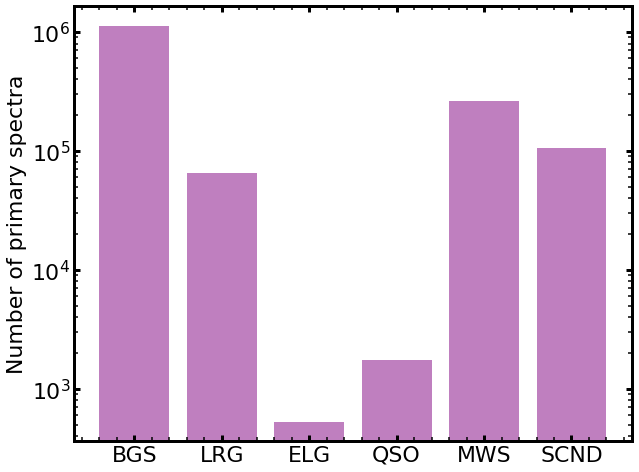

In [22]:
# Let us look at the numbers visually - 

plt.figure(figsize = (10, 8))

targets = ['BGS', 'LRG', 'ELG', 'QSO', 'MWS', 'SCND']
numbers = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]

plt.bar(targets, numbers, color = 'purple', alpha = 0.5)
plt.ylabel('Number of primary spectra')
plt.yscale('log')

Text(0.5, 0, 'Redshift')

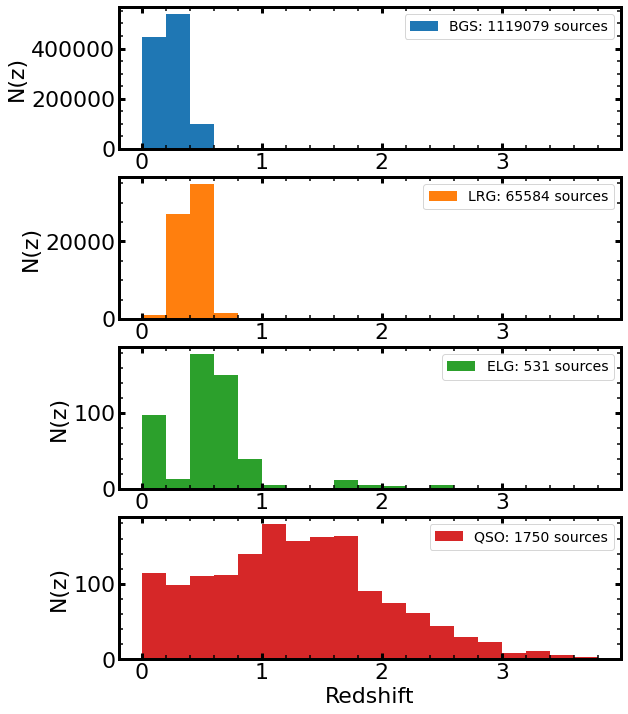

In [23]:
# Now let us look at the distribution of redshifts -

fig, axs = plt.subplots(4, 1, figsize = (9, 12))
bins = np.arange(0, 4, 0.2)

axs[0].hist(zcat['Z'][is_bgs], color = 'C0', bins = bins, label = f'BGS: {len(zcat[is_bgs])} sources')
axs[0].legend(fontsize = 14)
axs[0].set_ylabel("N(z)")
axs[1].hist(zcat['Z'][is_lrg], color = 'C1', bins = bins, label = f'LRG: {len(zcat[is_lrg])} sources')
axs[1].legend(fontsize = 14)
axs[1].set_ylabel("N(z)")
axs[2].hist(zcat['Z'][is_elg], color = 'C2', bins = bins, label = f'ELG: {len(zcat[is_elg])} sources')
axs[2].legend(fontsize = 14)
axs[2].set_ylabel("N(z)")
axs[3].hist(zcat['Z'][is_qso], color = 'C3', bins = bins, label = f'QSO: {len(zcat[is_qso])} sources')
axs[3].legend(fontsize = 14)
axs[3].set_ylabel("N(z)")
axs[3].set_xlabel("Redshift")


#### Other masks

`desi_mask` consists of the uppermost level targeting information in DESI. However, there can be sub-classes of targets. For example, BGS have different target masks depending on the selection criterion. Each of the different secondary target proposals have their own masks. They can be selected in a similar way as above, but with the respective columns in the redshift catalog.

In [24]:
bgs_mask.names

<bound method BitMask.names of bgs_mask:
  - [BGS_FAINT,        0, "BGS faint targets", {'obsconditions': 'BRIGHT', 'priorities': {'UNOBS': 2000, 'MORE_ZGOOD': 2, 'MORE_ZWARN': 2, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0}, 'numobs': 2}]
  - [BGS_BRIGHT,       1, "BGS bright targets", {'obsconditions': 'BRIGHT', 'priorities': {'UNOBS': 2100, 'MORE_ZGOOD': 2, 'MORE_ZWARN': 2, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0}, 'numobs': 2}]
  - [BGS_WISE,         2, "BGS wise targets", {'obsconditions': 'BRIGHT', 'priorities': {'UNOBS': 2000, 'MORE_ZGOOD': 2, 'MORE_ZWARN': 2, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0}, 'numobs': 2}]
  - [BGS_FAINT_HIP,    3, "BGS faint targets at bright priority", {'obsconditions': 'BRIGHT', 'priorities': {'UNOBS': 2100, 'MORE_ZGOOD': 2, 'MORE_ZWARN': 2, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0}, 'numobs': 2}]
  - [BGS_FAINT_NORTH,  8, "BGS faint cuts tuned for Bok/Mosaic", {'obsconditions': 'BRIG

In [25]:
scnd_mask.names

<bound method BitMask.names of scnd_mask:
  - [VETO,             0, "Never observe, even if a primary target bit is set.", {'obsconditions': 'DARK|GRAY|BRIGHT|BACKUP|TWILIGHT12|TWILIGHT18', 'filename': 'veto', 'flavor': 'SPARE', 'downsample': 1, 'updatemws': False, 'priorities': {'UNOBS': 0, 'MORE_ZGOOD': 0, 'MORE_ZWARN': 0, 'DONE': 0, 'OBS': 0, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0}, 'numobs': 1}]
  - [UDG,              1, "See $SCND_DIR/docs/UDG.txt", {'obsconditions': 'DARK', 'filename': 'UDG', 'flavor': 'SPARE', 'updatemws': False, 'downsample': 1, 'priorities': {'UNOBS': 1900, 'MORE_ZGOOD': 2, 'MORE_ZWARN': 2, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0}, 'numobs': 1}]
  - [FIRST_MALS,       2, "See $SCND_DIR/docs/FIRST_MALS.txt", {'obsconditions': 'DARK', 'filename': 'FIRST_MALS', 'flavor': 'SPARE', 'updatemws': False, 'downsample': 1, 'priorities': {'UNOBS': 1025, 'MORE_ZGOOD': 2, 'MORE_ZWARN': 2, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0}, 'numobs':

Now, we will explore the Healpix/ directory and see how to access the required coadded spectra

<a class="anchor" id="hpx"></a>
## Healpix/ Directory

This directory divides the coadded spectra of targets based on the healpix number and the observing conditions (dark/bright).

In [26]:
healpix_dir = f'{everest_dir}/healpix'

In [27]:
os.listdir(healpix_dir)

['main', 'tilepix.json', 'sv2', 'sv3', 'tilepix.fits', 'sv1']

The directories in `healpix` folder are divided based on the survey and then by the `FAPRGRM` (dark or bright)

In [28]:
os.listdir(f'{healpix_dir}/{survey}')

['bright', 'dark']

In [29]:
sorted(os.listdir(f'{healpix_dir}/{survey}/{faprgrm}'))[0:10]

['100', '101', '102', '103', '104', '105', '106', '107', '108', '110']

<a class="anchor" id="spectra_access"></a>
# Accessing and Plotting Spectra of a Single Object

Under the healpix/ directory, the different healpix directories are grouped together in healpix subgroups. 

To access a particular coadded spectra, we need the following information:

* **survey**: SURVEY that the target was observed in. This can be sv1, sv2, sv3, or main.
* **faprgrm**: FIBER ASSIGNMENT PROGRAM. This is the planned observing conditions for the target. It can be dark or bright. In the case of sv1, we also have "other" or "backup".
* **healpix**: HEALPIX Number, which depends on the position of the object in the sky.

The coadd filepath can be created using this -
```
{healpix_directory}/{survey}/{faprgrm}/{healpix_group}/{healpix}/coadd-{survey}-{faprgrm}-{healpix}.fits
```
The healpix group can be derived from the healpix number. 

In [30]:
# Note that the healpix column in the zpix-* catalogs (if present) are not always correct. 
# This will be fixed in Fuji
# If you have RA and DEC of a target, you can compute the healpix using the following code:

hpx = np.array(radec2pix(nside = 64, ra = zcat['TARGET_RA'].data, dec = zcat['TARGET_DEC'].data)).astype(str)
# The hpx values are integer values, but have been converted here into string (for easier access to the file path)

In [31]:
# Selecting a random object based using the index - 
targets = zcat['TARGETID'].data
index = 10

# Let us explore the target directory
# However, it is easier to keep it like this, if we want to explore other survey targets
# Note: survey and faprgrm have been defined earlier.
tgt_dir = f'{healpix_dir}/{survey}/{faprgrm}/{hpx[index][:-2]}/{hpx[index]}'

In [32]:
os.listdir(tgt_dir)

['spectra-main-bright-10001.fits',
 'logs',
 'redrock-main-bright-10001.fits',
 'coadd-main-bright-10001.fits',
 'rrdetails-main-bright-10001.h5']

In every directory, we have the following files: 

* **spectra-{survey}-{fapgrm}-{healpix}.fits**: This file contains all the individual exposure spectra that go into the coadds.
* **coadd-{survey}-{fapgrm}-{healpix}.fits**: This file contains the coadded spectra of the targets
* **redrock-{survey}-{fapgrm}-{healpix}.fits**: This file contains the redshift information obtained from the redrock.
* **rrdetails-{survey}-{faprgrm}-{healpix}.h5**: These files contain information about the templates used by redrock.
* **qso_mgii-{survey}-{fapgrm}-{healpix}.fits**: This file contains the redshift information after using MgII selection for QSOs. This is run on the redrock output. For Everest this only exists if QSO targets are in the redshift file. 
* **qso_qn-{survey}-{fapgrm}-{healpix}.fits**: This file contains the redshift information after running the redrock output through QuasarNet. For Everest this only exists if QSO targets are in the redshift file. 
* **logs**: Directory containing logs from the processing of the data. You can safely ignore this.

Let us explore the coadd* and redrock* files

### Healpix based coadd file

In [33]:
# Filename - 
coadd_filename = f'coadd-{survey}-{faprgrm}-{hpx[index]}.fits'

In [34]:
h_coadd = fits.open(f'{tgt_dir}/{coadd_filename}')
h_coadd.info()

Filename: /global/cfs/cdirs/desi/spectro/redux/everest/healpix/main/bright/100/10001/coadd-main-bright-10001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   ()      
  1  FIBERMAP      1 BinTableHDU    146   460R x 67C   [K, J, D, D, E, E, E, K, B, 3A, D, J, I, J, J, 4A, E, E, E, E, E, E, I, K, 2A, E, E, E, E, 8A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 1A, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, D, E, D, E, E]   
  2  EXP_FIBERMAP    1 BinTableHDU     64   460R x 26C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D]   
  3  B_WAVELENGTH    1 ImageHDU        10   (2751,)   float64   
  4  B_FLUX        1 ImageHDU        11   (2751, 460)   float32   
  5  B_IVAR        1 ImageHDU        11   (2751, 460)   float32   
  6  B_MASK        1 ImageHDU        12   (2751, 460)   int32 (rescales to uint32)   
  7  B_RESOLUTION    1 ImageHDU        11   (2751, 11, 460)   float32   
  8  R_WAVE

We can see that every coadd* file has 18 extensions:
* **FIBERMAP** consists of information about the different targets
* **EXP_FIBERMAP** contains the exposure information of the targets
* For every camera (B,R,Z), we have wavelength, flux, inverse variance and resolution arrays for the individual targets.
* **SCORES** contains more information about the coadds of the target spectra

Let us plot the position of different sources in the sky and overplot the different `Milky Way Survey (MWS)` sources

In [35]:
fm = Table(h_coadd['FIBERMAP'].data)
is_mws = (fm['DESI_TARGET'] & desi_mask['MWS_ANY']) != 0
h_coadd.close()

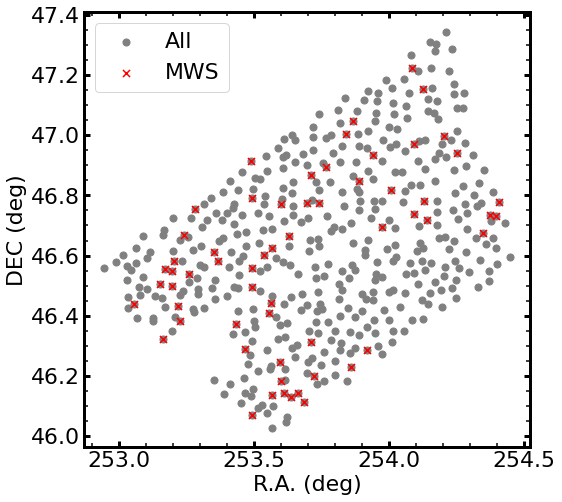

In [36]:
plt.figure(figsize = (8, 8))

plt.scatter(fm['TARGET_RA'], fm['TARGET_DEC'], color = 'grey', s = 50, label = 'All')
plt.scatter(fm['TARGET_RA'][is_mws], fm['TARGET_DEC'][is_mws], color = 'r', s = 50, marker = 'x', label = 'MWS')
plt.xlabel('R.A. (deg)')
plt.ylabel('DEC (deg)')
plt.legend()

### Healpix based redrock file

In [37]:
# Filename -
z_filename = f'redrock-{survey}-{faprgrm}-{hpx[index]}.fits'

In [38]:
h_rr = fits.open(f'{tgt_dir}/{z_filename}')
h_rr.info()
h_rr.close()

Filename: /global/cfs/cdirs/desi/spectro/redux/everest/healpix/main/bright/100/10001/redrock-main-bright-10001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   ()      
  1  REDSHIFTS     1 BinTableHDU     31   460R x 11C   [K, D, 10D, D, D, K, K, 6A, 20A, K, D]   
  2  FIBERMAP      1 BinTableHDU    143   460R x 67C   [K, J, D, D, E, E, E, K, B, 3A, D, J, I, J, J, 4A, E, E, E, E, E, E, I, K, 2A, E, E, E, E, 8A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 1A, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, D, E, D, E, E]   
  3  EXP_FIBERMAP    1 BinTableHDU     61   460R x 26C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D]   
  4  TSNR2         1 BinTableHDU     75   460R x 33C   [K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


The redrock* file has 4 extensions:

* **REDSHIFTS** consists of redshift information and outputs from redrock.
* **FIBERMAP** is similar to the one in coadd* file and has information about the targets.
* **EXP_FIBERMAP** is again similar to the one in the coadd* file and has exposure information about the targets
* **TSNR2** contains information about the expected SNR measurements for the targets

You can in principle use these files directly and write your own code to access the spectra. However, `desispec` also provides a function for accessing the coadded spectra as shown below.

<a class="anchor" id="spectra"></a>
### Working with Coadded Spectra using _desispec.io.read_spectra()_

In [39]:
# Using desispec to read the spectra

coadd_obj = desispec.io.read_spectra(f'{tgt_dir}/{coadd_filename}')
coadd_tgts = coadd_obj.target_ids().data

INFO:spectra.py:285:read_spectra: iotime 0.554 sec to read coadd-main-bright-10001.fits at 2022-05-31T10:07:23.024732


In [40]:
# Selecting the particular spectra of the targetid

row = (coadd_tgts == targets[index])
coadd_spec = coadd_obj[row]

In [41]:
coadd_spec.wave

{'b': array([3600. , 3600.8, 3601.6, ..., 5798.4, 5799.2, 5800. ]),
 'r': array([5760. , 5760.8, 5761.6, ..., 7618.4, 7619.2, 7620. ]),
 'z': array([7520. , 7520.8, 7521.6, ..., 9822.4, 9823.2, 9824. ])}

In [42]:
coadd_spec.flux

{'b': array([[-19.34148598,   3.243855  ,  26.75823975, ...,   2.02868319,
           2.73550797,   1.71373963]]),
 'r': array([[-6.27108145, 19.6212635 , -6.39838219, ...,  0.81333429,
          2.35510707, -5.46396875]]),
 'z': array([[2.75261664, 2.67584538, 1.66051161, ..., 2.20494103, 2.96566939,
         1.97142506]])}

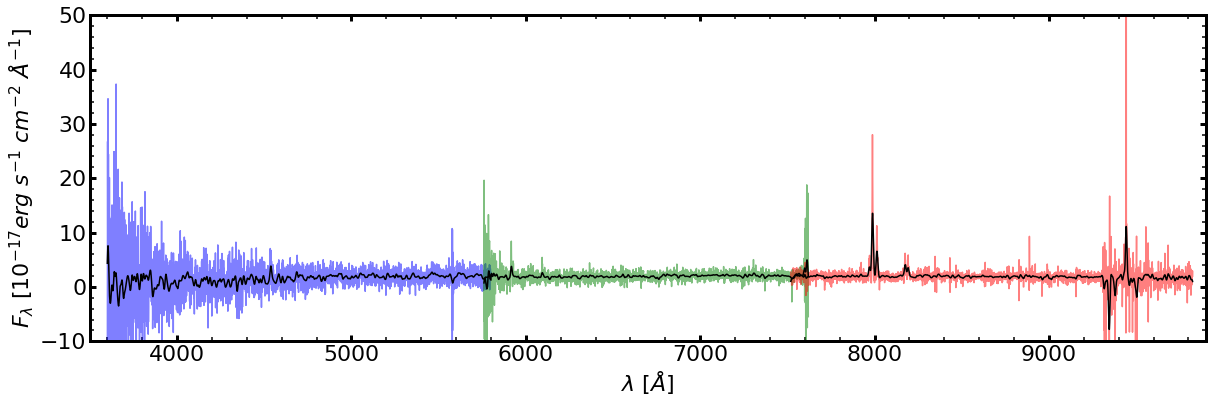

In [43]:
# Plotting this spectra -

plt.figure(figsize = (20, 6))
# Plot the spectrum from each arm (B,R,Z) in blue, green, red

plt.plot(coadd_spec.wave['b'], coadd_spec.flux['b'][0], color = 'b', alpha = 0.5)
plt.plot(coadd_spec.wave['r'], coadd_spec.flux['r'][0], color = 'g', alpha = 0.5)
plt.plot(coadd_spec.wave['z'], coadd_spec.flux['z'][0], color = 'r', alpha = 0.5)
# Over-plotting smoothed spectra in black for all the three arms
plt.plot(coadd_spec.wave['b'], convolve(coadd_spec.flux['b'][0], Gaussian1DKernel(5)), color = 'k')
plt.plot(coadd_spec.wave['r'], convolve(coadd_spec.flux['r'][0], Gaussian1DKernel(5)), color = 'k')
plt.plot(coadd_spec.wave['z'], convolve(coadd_spec.flux['z'][0], Gaussian1DKernel(5)), color = 'k')
plt.xlim([3500, 9900])
plt.ylim([-10,50])     ## You can change this depending on the spectra
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

The coadded spectra available is divided based on the observed (B,R,Z) camera. We can obtain the joint spectrum using the available `coaddition.coadd_cameras` function.

In [44]:
# Combined Spectra - 

spec_combined = coaddition.coadd_cameras(coadd_spec)

In [45]:
spec_combined.wave

{'brz': array([3600. , 3600.8, 3601.6, ..., 9822.4, 9823.2, 9824. ])}

In [46]:
spec_combined.flux

{'brz': array([[-19.34148598,   3.243855  ,  26.75823975, ...,   2.20494103,
           2.96566939,   1.97142506]])}

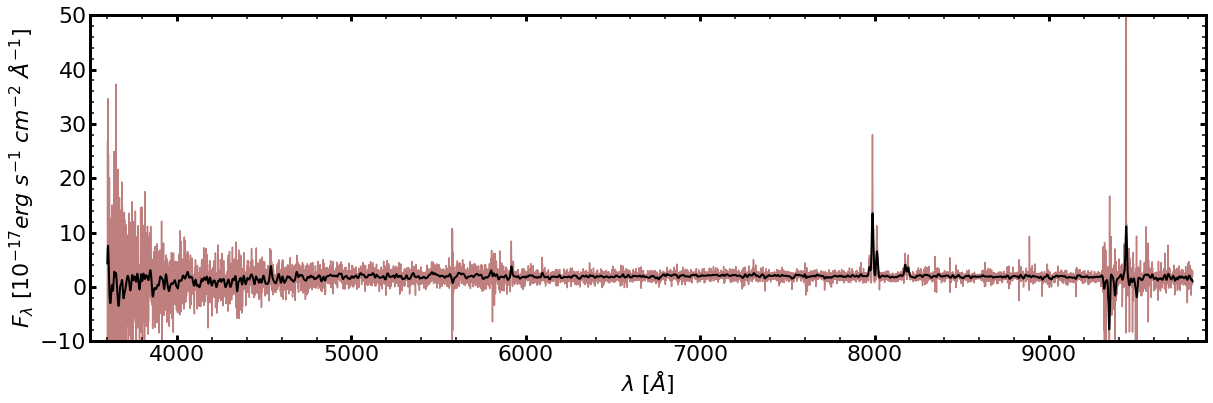

In [47]:
# Plotting this combined spectra - 

# Plotting this spectra -

plt.figure(figsize = (20, 6))
# Plot the combined spectrum in maroon
plt.plot(spec_combined.wave['brz'], spec_combined.flux['brz'][0], color = 'maroon', alpha = 0.5)
# Over-plotting smoothed spectra 
plt.plot(spec_combined.wave['brz'], convolve(spec_combined.flux['brz'][0], Gaussian1DKernel(5)), color = 'k', lw = 2.0)
plt.xlim([3500, 9900])
plt.ylim([-10,50])
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

---

<a class="anchor" id="bits"></a>
# Brief Overview of Bits, Bitmasks, and Flags

Bitmasks are often used in astronomy for storing targeting or quality cut information. It is therefore important to learn how to work with them. <br/>
The idea of using bitmasks depends on the binary representation, where each bit can either take values of `0` or `1`. Each bit in the binary number is allotted a property, which can either be set to be TRUE (1) or FALSE (0). In other words, these bits have encoded information called "flags". Since all integers are stored as sets of bits, these strings of bits are often displayed in their base 10 representation.

For example, if there is a bitmask with three bits (assuming each bit is related to some target information), then it can take the following values - 
* $000$ - $2^{2}\times0$ + $2^{1}\times0$ + $2^{0}\times0$ = $0$
* $001$ - $2^{2}\times0$ + $2^{1}\times0$ + $2^{0}\times1$ = $1$
* $010$ - $2^{2}\times0$ + $2^{1}\times1$ + $2^{0}\times0$ = $2$
* $011$ - $2^{2}\times0$ + $2^{1}\times1$ + $2^{0}\times1$ = $3$
* $100$ - $2^{2}\times1$ + $2^{1}\times0$ + $2^{0}\times0$ = $4$
* $101$ - $2^{2}\times1$ + $2^{1}\times0$ + $2^{0}\times1$ = $5$
* $110$ - $2^{2}\times1$ + $2^{1}\times1$ + $2^{0}\times0$ = $6$
* $111$ - $2^{2}\times1$ + $2^{1}\times1$ + $2^{0}\times1$ = $7$

Thus, a n-bit number can have an integer value from 0 to $2^{n}~-~1$. Typical flagging columns are either 32 or 64 bits.

### Using Bitmasks to get Flag Information

To check whether a particular bit is set or not, we use "bitwise and" on the bitmask. For example, lets say we have flag = 5, and we want to see which bits are set - 

| Flag Value |   Bit 2   |    Bit 1    |     Bit 0    |    Bitwise &    |
|------------|-----------|-------------|--------------|-----------------|
|  flag = 5  |     1     |      0      |       1      |       --        |
|$2^{0}$ = 1 |     0     |      0      |       1      | (flag & 1 != 0) |
|$2^{1}$ = 2 |     0     |      1      |       0      | (flag & 2 == 0) |
|$2^{2}$ = 4 |     1     |      0      |       0      | (flag & 4 != 0) |

To check if bit 'm' is set in a 'flag_value', then we check (flag_value & $2^{m}$) is True or False. If it is True, then bit 'm' is set. If it is False, then bit 'm' is not set. 

---